In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, pipeline_Richard, pipeline_Julian
from pipelines import categorical_input_columns

RANDOM_STATE = 1234

In [3]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [4]:
load_process_and_store_spreadsheets(transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

In [5]:
categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]

In [6]:
# from imblearn.over_sampling import SMOTENC
# SMOTENC(
#     categorical_features=categorical_feature_indices, random_state=RANDOM_STATE
# ).fit_resample(X_train, y_train)

## Classification

In [7]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

In [8]:
ps_class = build_classifier_pipelines()

We want to predict non-responders:

In [9]:
response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'
# pos_label = 'responder (pr+cr)'

In [10]:
F1 = lambda x, y: f1_score(x, y, labels=response_labels, pos_label=pos_label)

In [11]:
from catboost import CatBoostClassifier
params = {
    'iterations': 400,
    'random_seed': RANDOM_STATE,
    'custom_loss': ['Precision', 'AUC', 'Accuracy', 'F1', 'Recall'],
    'eval_metric': 'F1',
    'logging_level': 'Silent',
}
cat = CatBoostClassifier(**params)

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]

In [14]:
# cat.fit(
#     X_train, y_train_resp,
#     cat_features=categorical_feature_indices,
#     plot=True,
#     eval_set=(X_test, y_test_resp),
# )

## Architecure pipeline

In [15]:
# Calculate F_1 scores for the classifiers.
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=F1,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.705882,0.765957,0.666667,0.862069
RandomForestClassifier,0.766667,0.695652,0.847458,0.812500
GaussianNB,0.690909,0.294118,0.550000,0.714286
GradientBoostingClassifier,0.843750,0.865672,0.861538,0.865672
KNeighborsClassifier,0.786885,0.771930,0.771930,0.825397
LogisticRegression,0.807018,0.000000,0.754717,0.807018
SVC,0.865672,0.865672,0.865672,0.865672
DummyClassifier,0.865672,0.865672,0.865672,0.865672


In [16]:
print(b.max(axis=0))
print('--'*10)
print(b.max(axis=1))

Richard_test    0.865672
Julian_test     0.865672
Freeman_test    0.865672
Lev_test        0.865672
dtype: float64
--------------------
DecisionTreeClassifier        0.862069
RandomForestClassifier        0.847458
GaussianNB                    0.714286
GradientBoostingClassifier    0.865672
KNeighborsClassifier          0.825397
LogisticRegression            0.807018
SVC                           0.865672
DummyClassifier               0.865672
dtype: float64


In [17]:
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [18]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=auc,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.588123,0.810345,0.609195,0.708812
RandomForestClassifier,0.452107,0.720307,0.653257,0.448276
GaussianNB,0.438697,0.586207,0.689655,0.455939
GradientBoostingClassifier,0.521073,0.500000,0.538314,0.500000
KNeighborsClassifier,0.469349,0.545977,0.545977,0.503831
LogisticRegression,0.618774,0.500000,0.622605,0.618774
SVC,0.500000,0.500000,0.500000,0.500000
DummyClassifier,0.500000,0.500000,0.500000,0.500000


In [19]:
print(b.max(axis=0))
print('--'*10)
print(b.max(axis=1))

Richard_test    0.618774
Julian_test     0.810345
Freeman_test    0.689655
Lev_test        0.708812
dtype: float64
--------------------
DecisionTreeClassifier        0.810345
RandomForestClassifier        0.720307
GaussianNB                    0.689655
GradientBoostingClassifier    0.538314
KNeighborsClassifier          0.545977
LogisticRegression            0.622605
SVC                           0.500000
DummyClassifier               0.500000
dtype: float64


In [20]:
X_train.columns

Index(['TP53', 'KRAS', 'FGFR1', 'PTEN', 'FBXW7', 'KDR', 'MTOR', 'EGFR', 'MET',
       'CDKN2A', 'BRAF', 'APC', 'KEAP1', 'ALK', 'AR', 'ERBB2', 'NRAS',
       'NFE2L2', 'TSC2', 'GNAS', 'STK11', 'CD274', 'CTNNB1', 'MAP2K2', 'IDH1',
       'NF2', 'MAP2K1', 'PIK3CA', 'IDH2', 'FLT4', 'ESR1', 'DDR2', 'KIT',
       'PTCH1', 'SMAD4', 'SMO', 'RNF43', 'FGFR2', 'JAK2', 'CCND1', 'GATA3',
       'PDGFRA', 'gender', 'leeftijd', 'stage', 'therapyline', 'smokingstatus',
       'Systemischetherapie', 'histology_grouped', 'lymfmeta', 'brainmeta',
       'adrenalmeta', 'livermeta', 'lungmeta', 'skeletonmeta'],
      dtype='object')

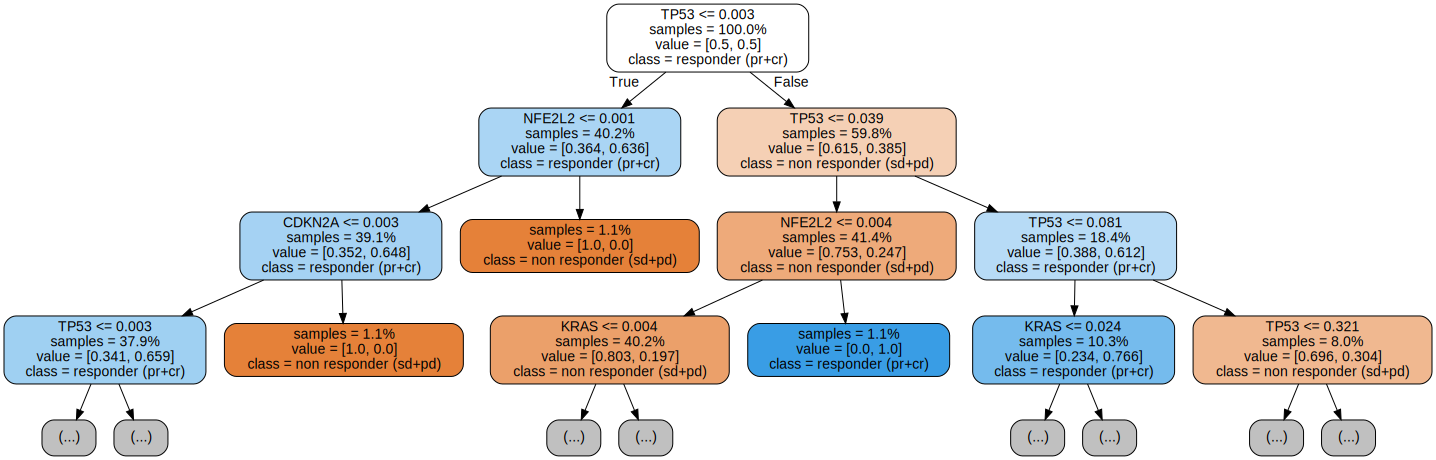

In [21]:
from views import view_decision_tree_julian
view_decision_tree_julian(ps_class['DecisionTreeClassifier']['Julian'])

In [22]:
from pipelines import hybrid_classifier
p = hybrid_classifier()
X_train, y_train_resp, X_test, y_test_resp
p.fit(X_train, y_train_resp)
y_train_pred = p.predict(X_train)
y_test_pred = p.predict(X_test)
auc(y_test_resp, y_test_pred)

0.6877394636015326

In [23]:
p_win = ps_class['DecisionTreeClassifier']['Julian']

The confusion matrix $M_{ij}$: predicted $i$ but truth is $j$.

Confusion matrix, without normalization
[[18 11]
 [ 0  9]]


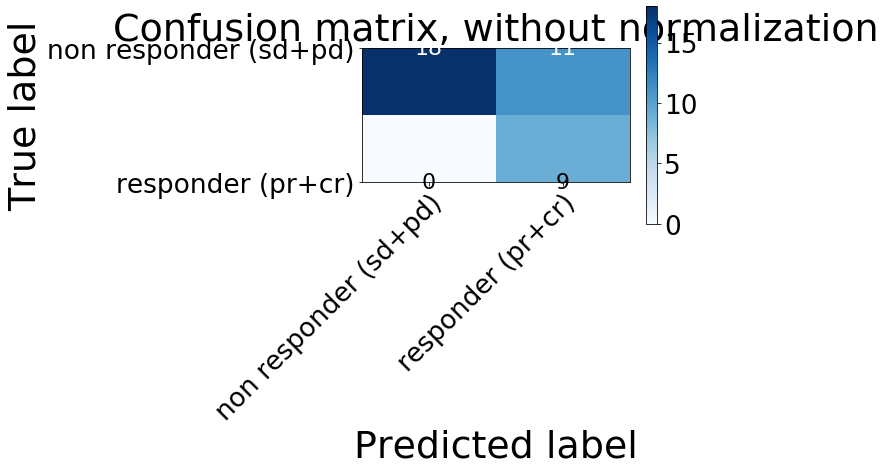

In [24]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

Precision:
$$p = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$$

Recall or sensitivity:
$$r = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$$

In [25]:
r = lambda x,y: recall_score(x, y, labels=response_labels, pos_label=pos_label)
p = lambda x, y: precision_score(x, y, labels=response_labels, pos_label=pos_label)
recall = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=r,
)
recall

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.620690,0.620690,0.551724,0.862069
RandomForestClassifier,0.793103,0.551724,0.862069,0.896552
GaussianNB,0.655172,0.172414,0.379310,0.689655
GradientBoostingClassifier,0.931034,1.000000,0.965517,1.000000
KNeighborsClassifier,0.827586,0.758621,0.758621,0.896552
LogisticRegression,0.793103,0.000000,0.689655,0.793103
SVC,1.000000,1.000000,1.000000,1.000000
DummyClassifier,1.000000,1.000000,1.000000,1.000000


In [26]:
precision = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=p,
)
precision

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.818182,1.000000,0.842105,0.862069
RandomForestClassifier,0.741935,0.941176,0.833333,0.742857
GaussianNB,0.730769,1.000000,1.000000,0.740741
GradientBoostingClassifier,0.771429,0.763158,0.777778,0.763158
KNeighborsClassifier,0.750000,0.785714,0.785714,0.764706
LogisticRegression,0.821429,0.000000,0.833333,0.821429
SVC,0.763158,0.763158,0.763158,0.763158
DummyClassifier,0.763158,0.763158,0.763158,0.763158


Confusion matrix, without normalization
[[ 4  5]
 [ 6 23]]


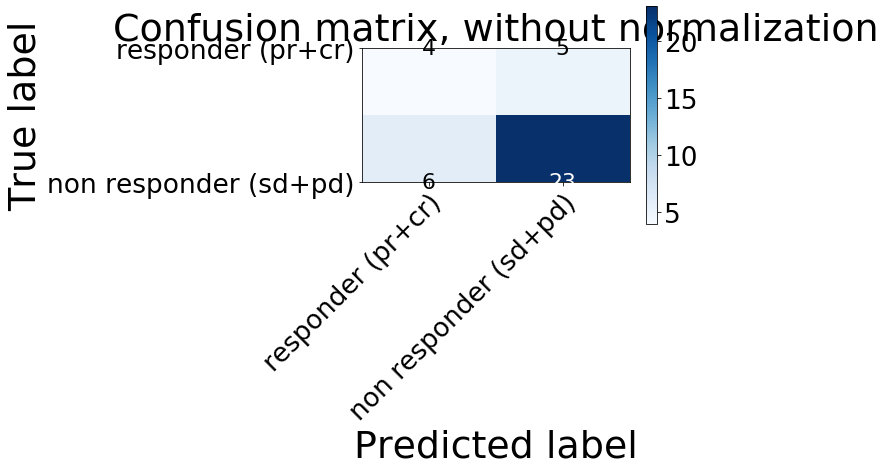

In [27]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps_class['LogisticRegression']['Lev'].predict(X_test), classes=y_test_resp.unique())

## Dimensional representation

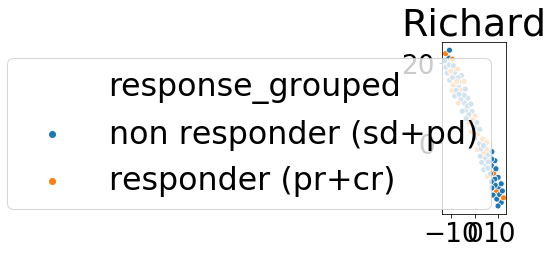

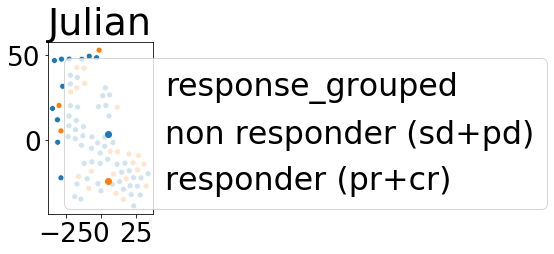

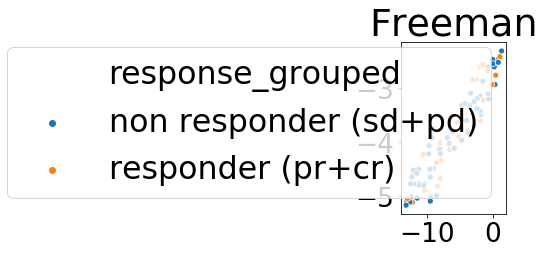

In [28]:
from views import view_pipelines

view_pipelines(ps_class['LogisticRegression'], X_train, y_train_resp, random_state=RANDOM_STATE)

## Regression

In [29]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']

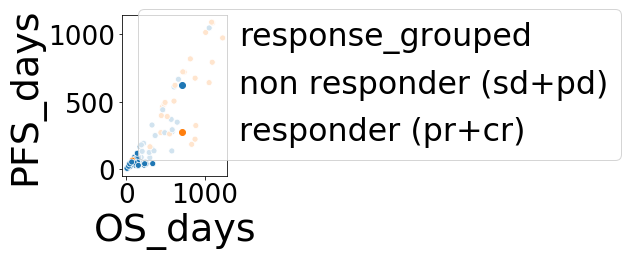

In [30]:
sns.scatterplot(x=y_train_os, y=y_train_pfs, hue=y_train_resp)

### Overall survival (OS)

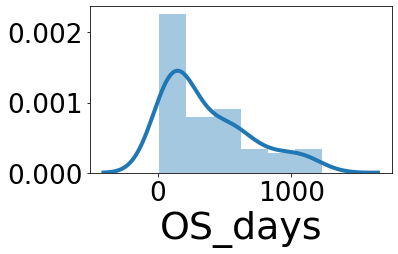

In [31]:
sns.distplot(y_train_os, norm_hist=False)

In [32]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [33]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    299.096680
Julian_test     273.258122
Freeman_test    513.556195
Lev_test        276.330940
dtype: float64
--------------------
DecisionTreeRegressor        309.392724
RandomForestRegressor        297.349653
GradientBoostingRegressor    281.641850
KNeighborsRegressor          336.464730
ElasticNet                   266.933369
LinearRegression             678.936748
SVR                          276.691990
DummyRegressor               277.072810
dtype: float64


In [34]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,331.221847,255.227153,381.503252,269.618643
RandomForestRegressor,321.659853,289.205408,287.635103,290.898249
GradientBoostingRegressor,289.469174,266.030076,302.617991,268.450157
KNeighborsRegressor,375.229392,289.899266,367.328402,313.401862
ElasticNet,259.423289,271.744500,273.215056,263.350630
LinearRegression,261.651308,260.780187,1942.032904,251.282592
SVR,277.045767,276.105578,277.044043,276.572572
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

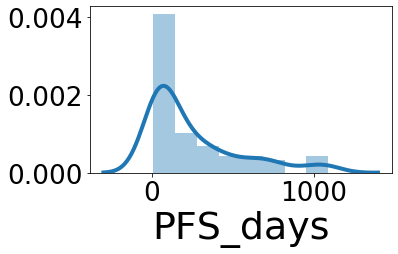

In [35]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [36]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [37]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    303.875527
Julian_test     293.137569
Freeman_test    386.611698
Lev_test        291.555687
dtype: float64
--------------------
DecisionTreeRegressor        318.488138
RandomForestRegressor        294.830123
GradientBoostingRegressor    283.852797
KNeighborsRegressor          328.403331
ElasticNet                   279.429569
LinearRegression             448.020966
SVR                          298.613495
DummyRegressor               298.722543
dtype: float64


In [38]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,350.008600,272.840127,353.411842,297.691983
RandomForestRegressor,303.547547,293.009093,294.235147,288.528707
GradientBoostingRegressor,284.497150,283.096726,287.819347,279.997963
KNeighborsRegressor,343.366697,320.053519,336.517371,313.675739
ElasticNet,274.675298,288.689546,274.302201,280.051230
LinearRegression,277.471223,290.240609,949.174965,275.197068
SVR,298.715156,298.448391,298.710170,298.580264
DummyRegressor,298.722543,298.722543,298.722543,298.722543


## Multitask model


In [39]:
from sklearn.linear_model import MultiTaskElasticNet
from pipelines import pipelines
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [40]:
Y_train = y_train[['OS_days', 'PFS_days']]
Y_test = y_test[['OS_days', 'PFS_days']]
rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)
# p = ps['Richard']
# p.fit(X_train, Y_train)

,Freeman_test,Julian_test,Richard_test
bla,"[269.6932269471216, 274.0262719127552]","[271.7399772705852, 288.69028307704565]","[260.11308550415055, 274.8461814804882]"
